# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 988us/sample - loss: 243.2167 - y1_output_loss: 121.3239 - y2_output_loss: 119.7742 - y1_output_root_mean_squared_error: 11.0632 - y2_output_root_mean_squared_error: 10.9919 - val_loss: 40.7057 - val_y1_output_loss: 19.5580 - val_y2_output_loss: 25.1996 - val_y1_output_root_mean_squared_error: 4.1872 - val_y2_output_root_mean_squared_error: 4.8138
Epoch 2/500
614/614 [==============================] - 0s 134us/sample - loss: 40.0930 - y1_output_loss: 14.5792 - y2_output_loss: 25.5705 - y1_output_root_mean_squared_error: 3.7987 - y2_output_root_mean_squared_error: 5.0659 - val_loss: 35.8692 - val_y1_output_loss: 16.5816 - val_y2_output_loss: 19.8854 - val_y1_output_root_mean_squared_error: 4.0419 - val_y2_output_root_mean_squared_error: 4.4196
Epoch 3/500
614/614 [==============================] - 0s 128us/sample - loss: 24.7270 - y1_output_loss: 10.1366 - y2_output_loss: 14.4210 - y1

614/614 [==============================] - 0s 142us/sample - loss: 14.4227 - y1_output_loss: 5.8360 - y2_output_loss: 8.5383 - y1_output_root_mean_squared_error: 2.4225 - y2_output_root_mean_squared_error: 2.9248 - val_loss: 15.4573 - val_y1_output_loss: 6.4191 - val_y2_output_loss: 9.9432 - val_y1_output_root_mean_squared_error: 2.4482 - val_y2_output_root_mean_squared_error: 3.0763
Epoch 22/500
614/614 [==============================] - 0s 132us/sample - loss: 17.4309 - y1_output_loss: 6.4493 - y2_output_loss: 11.0238 - y1_output_root_mean_squared_error: 2.5453 - y2_output_root_mean_squared_error: 3.3094 - val_loss: 26.8112 - val_y1_output_loss: 8.6938 - val_y2_output_loss: 18.3515 - val_y1_output_root_mean_squared_error: 2.9355 - val_y2_output_root_mean_squared_error: 4.2654
Epoch 23/500
614/614 [==============================] - 0s 130us/sample - loss: 16.3392 - y1_output_loss: 6.3213 - y2_output_loss: 10.1680 - y1_output_root_mean_squared_error: 2.4977 - y2_output_root_mean_square

614/614 [==============================] - 0s 130us/sample - loss: 7.8742 - y1_output_loss: 2.8436 - y2_output_loss: 5.0042 - y1_output_root_mean_squared_error: 1.6883 - y2_output_root_mean_squared_error: 2.2414 - val_loss: 24.8168 - val_y1_output_loss: 8.3471 - val_y2_output_loss: 17.2085 - val_y1_output_root_mean_squared_error: 2.8465 - val_y2_output_root_mean_squared_error: 4.0883
Epoch 42/500
614/614 [==============================] - 0s 130us/sample - loss: 8.0318 - y1_output_loss: 2.5304 - y2_output_loss: 5.4516 - y1_output_root_mean_squared_error: 1.5939 - y2_output_root_mean_squared_error: 2.3433 - val_loss: 7.7569 - val_y1_output_loss: 2.6410 - val_y2_output_loss: 5.3342 - val_y1_output_root_mean_squared_error: 1.5986 - val_y2_output_root_mean_squared_error: 2.2806
Epoch 43/500
614/614 [==============================] - 0s 130us/sample - loss: 7.8513 - y1_output_loss: 2.6770 - y2_output_loss: 5.2057 - y1_output_root_mean_squared_error: 1.6388 - y2_output_root_mean_squared_erro

Epoch 62/500
614/614 [==============================] - 0s 130us/sample - loss: 5.5204 - y1_output_loss: 1.5310 - y2_output_loss: 4.0811 - y1_output_root_mean_squared_error: 1.2151 - y2_output_root_mean_squared_error: 2.0110 - val_loss: 11.2940 - val_y1_output_loss: 4.6618 - val_y2_output_loss: 7.2328 - val_y1_output_root_mean_squared_error: 2.0819 - val_y2_output_root_mean_squared_error: 2.6381
Epoch 63/500
614/614 [==============================] - 0s 134us/sample - loss: 5.9850 - y1_output_loss: 1.6481 - y2_output_loss: 4.3617 - y1_output_root_mean_squared_error: 1.2894 - y2_output_root_mean_squared_error: 2.0791 - val_loss: 6.1356 - val_y1_output_loss: 1.6775 - val_y2_output_loss: 4.5885 - val_y1_output_root_mean_squared_error: 1.3107 - val_y2_output_root_mean_squared_error: 2.1018
Epoch 64/500
614/614 [==============================] - 0s 136us/sample - loss: 4.6781 - y1_output_loss: 1.2562 - y2_output_loss: 3.3906 - y1_output_root_mean_squared_error: 1.1234 - y2_output_root_mean_

Epoch 83/500
614/614 [==============================] - 0s 130us/sample - loss: 3.6410 - y1_output_loss: 0.8215 - y2_output_loss: 2.8100 - y1_output_root_mean_squared_error: 0.9063 - y2_output_root_mean_squared_error: 1.6792 - val_loss: 7.4479 - val_y1_output_loss: 2.7707 - val_y2_output_loss: 5.2028 - val_y1_output_root_mean_squared_error: 1.6178 - val_y2_output_root_mean_squared_error: 2.1979
Epoch 84/500
614/614 [==============================] - 0s 134us/sample - loss: 3.6185 - y1_output_loss: 0.8764 - y2_output_loss: 2.7327 - y1_output_root_mean_squared_error: 0.9288 - y2_output_root_mean_squared_error: 1.6601 - val_loss: 4.4026 - val_y1_output_loss: 1.2462 - val_y2_output_loss: 3.2140 - val_y1_output_root_mean_squared_error: 1.1323 - val_y2_output_root_mean_squared_error: 1.7665
Epoch 85/500
614/614 [==============================] - 0s 130us/sample - loss: 3.8690 - y1_output_loss: 1.0243 - y2_output_loss: 2.8824 - y1_output_root_mean_squared_error: 1.0057 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 131us/sample - loss: 2.3257 - y1_output_loss: 0.4970 - y2_output_loss: 1.9481 - y1_output_root_mean_squared_error: 0.7074 - y2_output_root_mean_squared_error: 1.3510 - val_loss: 43.9712 - val_y1_output_loss: 4.2961 - val_y2_output_loss: 40.5738 - val_y1_output_root_mean_squared_error: 2.0514 - val_y2_output_root_mean_squared_error: 6.3058
Epoch 105/500
614/614 [==============================] - 0s 131us/sample - loss: 13.0725 - y1_output_loss: 4.5951 - y2_output_loss: 8.3541 - y1_output_root_mean_squared_error: 2.1538 - y2_output_root_mean_squared_error: 2.9040 - val_loss: 2.8034 - val_y1_output_loss: 0.4779 - val_y2_output_loss: 2.3597 - val_y1_output_root_mean_squared_error: 0.6988 - val_y2_output_root_mean_squared_error: 1.5216
Epoch 106/500
614/614 [==============================] - 0s 137us/sample - loss: 2.7854 - y1_output_loss: 0.5957 - y2_output_loss: 2.1837 - y1_output_root_mean_squared_error: 0.7673 - y2_output_root_

614/614 [==============================] - 0s 138us/sample - loss: 2.1477 - y1_output_loss: 0.5102 - y2_output_loss: 1.6505 - y1_output_root_mean_squared_error: 0.7153 - y2_output_root_mean_squared_error: 1.2791 - val_loss: 3.3105 - val_y1_output_loss: 0.4747 - val_y2_output_loss: 3.0082 - val_y1_output_root_mean_squared_error: 0.6945 - val_y2_output_root_mean_squared_error: 1.6817
Epoch 125/500
614/614 [==============================] - 0s 138us/sample - loss: 1.7284 - y1_output_loss: 0.3742 - y2_output_loss: 1.3567 - y1_output_root_mean_squared_error: 0.6110 - y2_output_root_mean_squared_error: 1.1641 - val_loss: 3.0027 - val_y1_output_loss: 0.8266 - val_y2_output_loss: 2.2460 - val_y1_output_root_mean_squared_error: 0.9043 - val_y2_output_root_mean_squared_error: 1.4781
Epoch 126/500
614/614 [==============================] - 0s 140us/sample - loss: 2.1484 - y1_output_loss: 0.4478 - y2_output_loss: 1.7216 - y1_output_root_mean_squared_error: 0.6684 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 138us/sample - loss: 1.8647 - y1_output_loss: 0.4287 - y2_output_loss: 1.4292 - y1_output_root_mean_squared_error: 0.6568 - y2_output_root_mean_squared_error: 1.1972 - val_loss: 2.5912 - val_y1_output_loss: 0.4528 - val_y2_output_loss: 2.1969 - val_y1_output_root_mean_squared_error: 0.6777 - val_y2_output_root_mean_squared_error: 1.4601
Epoch 146/500
614/614 [==============================] - 0s 139us/sample - loss: 3.0049 - y1_output_loss: 0.6188 - y2_output_loss: 2.3650 - y1_output_root_mean_squared_error: 0.7887 - y2_output_root_mean_squared_error: 1.5437 - val_loss: 2.1559 - val_y1_output_loss: 0.4939 - val_y2_output_loss: 1.6581 - val_y1_output_root_mean_squared_error: 0.7126 - val_y2_output_root_mean_squared_error: 1.2838
Epoch 147/500
614/614 [==============================] - 0s 139us/sample - loss: 1.6879 - y1_output_loss: 0.3232 - y2_output_loss: 1.3674 - y1_output_root_mean_squared_error: 0.5641 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 1.7796 - y1_output_loss: 0.4060 - y2_output_loss: 1.3751 - y1_output_root_mean_squared_error: 0.6356 - y2_output_root_mean_squared_error: 1.1728 - val_loss: 2.1352 - val_y1_output_loss: 0.3927 - val_y2_output_loss: 1.7324 - val_y1_output_root_mean_squared_error: 0.6295 - val_y2_output_root_mean_squared_error: 1.3187
Epoch 166/500
614/614 [==============================] - 0s 130us/sample - loss: 1.2155 - y1_output_loss: 0.2793 - y2_output_loss: 0.9469 - y1_output_root_mean_squared_error: 0.5261 - y2_output_root_mean_squared_error: 0.9689 - val_loss: 2.3614 - val_y1_output_loss: 0.7222 - val_y2_output_loss: 1.6332 - val_y1_output_root_mean_squared_error: 0.8546 - val_y2_output_root_mean_squared_error: 1.2771
Epoch 167/500
614/614 [==============================] - 0s 135us/sample - loss: 1.4477 - y1_output_loss: 0.3039 - y2_output_loss: 1.1604 - y1_output_root_mean_squared_error: 0.5414 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 137us/sample - loss: 1.1558 - y1_output_loss: 0.2530 - y2_output_loss: 0.8944 - y1_output_root_mean_squared_error: 0.5043 - y2_output_root_mean_squared_error: 0.9495 - val_loss: 1.5530 - val_y1_output_loss: 0.2475 - val_y2_output_loss: 1.2874 - val_y1_output_root_mean_squared_error: 0.4951 - val_y2_output_root_mean_squared_error: 1.1436
Epoch 187/500
614/614 [==============================] - 0s 142us/sample - loss: 1.2455 - y1_output_loss: 0.2618 - y2_output_loss: 1.0018 - y1_output_root_mean_squared_error: 0.5045 - y2_output_root_mean_squared_error: 0.9955 - val_loss: 1.7821 - val_y1_output_loss: 0.2910 - val_y2_output_loss: 1.5559 - val_y1_output_root_mean_squared_error: 0.5452 - val_y2_output_root_mean_squared_error: 1.2185
Epoch 188/500
614/614 [==============================] - 0s 137us/sample - loss: 1.0712 - y1_output_loss: 0.2558 - y2_output_loss: 0.8075 - y1_output_root_mean_squared_error: 0.5063 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 1.6123 - y1_output_loss: 0.3460 - y2_output_loss: 1.2537 - y1_output_root_mean_squared_error: 0.5907 - y2_output_root_mean_squared_error: 1.1240 - val_loss: 1.5650 - val_y1_output_loss: 0.3261 - val_y2_output_loss: 1.2308 - val_y1_output_root_mean_squared_error: 0.5494 - val_y2_output_root_mean_squared_error: 1.1239
Epoch 207/500
614/614 [==============================] - 0s 132us/sample - loss: 1.0949 - y1_output_loss: 0.2290 - y2_output_loss: 0.8599 - y1_output_root_mean_squared_error: 0.4765 - y2_output_root_mean_squared_error: 0.9316 - val_loss: 1.6656 - val_y1_output_loss: 0.2644 - val_y2_output_loss: 1.3728 - val_y1_output_root_mean_squared_error: 0.5018 - val_y2_output_root_mean_squared_error: 1.1890
Epoch 208/500
614/614 [==============================] - 0s 137us/sample - loss: 1.0617 - y1_output_loss: 0.2165 - y2_output_loss: 0.8479 - y1_output_root_mean_squared_error: 0.4650 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 133us/sample - loss: 0.9354 - y1_output_loss: 0.1979 - y2_output_loss: 0.7333 - y1_output_root_mean_squared_error: 0.4464 - y2_output_root_mean_squared_error: 0.8580 - val_loss: 1.7428 - val_y1_output_loss: 0.3426 - val_y2_output_loss: 1.3911 - val_y1_output_root_mean_squared_error: 0.5842 - val_y2_output_root_mean_squared_error: 1.1839
Epoch 228/500
614/614 [==============================] - 0s 129us/sample - loss: 0.9589 - y1_output_loss: 0.1850 - y2_output_loss: 0.7689 - y1_output_root_mean_squared_error: 0.4315 - y2_output_root_mean_squared_error: 0.8790 - val_loss: 1.6496 - val_y1_output_loss: 0.3278 - val_y2_output_loss: 1.2963 - val_y1_output_root_mean_squared_error: 0.5778 - val_y2_output_root_mean_squared_error: 1.1471
Epoch 229/500
614/614 [==============================] - 0s 131us/sample - loss: 1.3167 - y1_output_loss: 0.3276 - y2_output_loss: 0.9808 - y1_output_root_mean_squared_error: 0.5729 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.8804 - y1_output_loss: 0.1808 - y2_output_loss: 0.6916 - y1_output_root_mean_squared_error: 0.4270 - y2_output_root_mean_squared_error: 0.8355 - val_loss: 1.5238 - val_y1_output_loss: 0.2916 - val_y2_output_loss: 1.2253 - val_y1_output_root_mean_squared_error: 0.5368 - val_y2_output_root_mean_squared_error: 1.1116
Epoch 248/500
614/614 [==============================] - 0s 130us/sample - loss: 1.1003 - y1_output_loss: 0.2214 - y2_output_loss: 0.8743 - y1_output_root_mean_squared_error: 0.4697 - y2_output_root_mean_squared_error: 0.9379 - val_loss: 1.7902 - val_y1_output_loss: 0.3504 - val_y2_output_loss: 1.4468 - val_y1_output_root_mean_squared_error: 0.5692 - val_y2_output_root_mean_squared_error: 1.2108
Epoch 249/500
614/614 [==============================] - 0s 135us/sample - loss: 0.8525 - y1_output_loss: 0.1956 - y2_output_loss: 0.6575 - y1_output_root_mean_squared_error: 0.4390 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 128us/sample - loss: 0.7296 - y1_output_loss: 0.1654 - y2_output_loss: 0.5673 - y1_output_root_mean_squared_error: 0.4041 - y2_output_root_mean_squared_error: 0.7525 - val_loss: 1.2257 - val_y1_output_loss: 0.2129 - val_y2_output_loss: 1.0055 - val_y1_output_root_mean_squared_error: 0.4519 - val_y2_output_root_mean_squared_error: 1.0107
Epoch 269/500
614/614 [==============================] - 0s 133us/sample - loss: 0.7428 - y1_output_loss: 0.1787 - y2_output_loss: 0.5589 - y1_output_root_mean_squared_error: 0.4241 - y2_output_root_mean_squared_error: 0.7503 - val_loss: 1.1619 - val_y1_output_loss: 0.1753 - val_y2_output_loss: 0.9697 - val_y1_output_root_mean_squared_error: 0.4158 - val_y2_output_root_mean_squared_error: 0.9945
Epoch 270/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6629 - y1_output_loss: 0.1460 - y2_output_loss: 0.5156 - y1_output_root_mean_squared_error: 0.3818 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 0.6506 - y1_output_loss: 0.1483 - y2_output_loss: 0.4969 - y1_output_root_mean_squared_error: 0.3865 - y2_output_root_mean_squared_error: 0.7079 - val_loss: 1.2931 - val_y1_output_loss: 0.2128 - val_y2_output_loss: 1.0621 - val_y1_output_root_mean_squared_error: 0.4605 - val_y2_output_root_mean_squared_error: 1.0398
Epoch 289/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6825 - y1_output_loss: 0.1635 - y2_output_loss: 0.5145 - y1_output_root_mean_squared_error: 0.4041 - y2_output_root_mean_squared_error: 0.7205 - val_loss: 1.2127 - val_y1_output_loss: 0.2640 - val_y2_output_loss: 0.9536 - val_y1_output_root_mean_squared_error: 0.5214 - val_y2_output_root_mean_squared_error: 0.9700
Epoch 290/500
614/614 [==============================] - 0s 134us/sample - loss: 0.6368 - y1_output_loss: 0.1473 - y2_output_loss: 0.4913 - y1_output_root_mean_squared_error: 0.3814 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6134 - y1_output_loss: 0.1489 - y2_output_loss: 0.4624 - y1_output_root_mean_squared_error: 0.3869 - y2_output_root_mean_squared_error: 0.6810 - val_loss: 1.6458 - val_y1_output_loss: 0.2100 - val_y2_output_loss: 1.5003 - val_y1_output_root_mean_squared_error: 0.4647 - val_y2_output_root_mean_squared_error: 1.1958
Epoch 310/500
614/614 [==============================] - 0s 134us/sample - loss: 0.7850 - y1_output_loss: 0.1802 - y2_output_loss: 0.5988 - y1_output_root_mean_squared_error: 0.4255 - y2_output_root_mean_squared_error: 0.7771 - val_loss: 1.2326 - val_y1_output_loss: 0.2210 - val_y2_output_loss: 1.0673 - val_y1_output_root_mean_squared_error: 0.4733 - val_y2_output_root_mean_squared_error: 1.0043
Epoch 311/500
614/614 [==============================] - 0s 134us/sample - loss: 0.8909 - y1_output_loss: 0.2025 - y2_output_loss: 0.6899 - y1_output_root_mean_squared_error: 0.4503 - y2_output_root_mea

614/614 [==============================] - 0s 128us/sample - loss: 0.5462 - y1_output_loss: 0.1360 - y2_output_loss: 0.4231 - y1_output_root_mean_squared_error: 0.3663 - y2_output_root_mean_squared_error: 0.6419 - val_loss: 3.7229 - val_y1_output_loss: 0.2615 - val_y2_output_loss: 3.6271 - val_y1_output_root_mean_squared_error: 0.5174 - val_y2_output_root_mean_squared_error: 1.8588
Epoch 330/500
614/614 [==============================] - 0s 131us/sample - loss: 0.6737 - y1_output_loss: 0.1638 - y2_output_loss: 0.5066 - y1_output_root_mean_squared_error: 0.4058 - y2_output_root_mean_squared_error: 0.7134 - val_loss: 1.0635 - val_y1_output_loss: 0.1897 - val_y2_output_loss: 0.8557 - val_y1_output_root_mean_squared_error: 0.4283 - val_y2_output_root_mean_squared_error: 0.9381
Epoch 331/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4960 - y1_output_loss: 0.1503 - y2_output_loss: 0.3548 - y1_output_root_mean_squared_error: 0.3724 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 132us/sample - loss: 0.5757 - y1_output_loss: 0.1630 - y2_output_loss: 0.4145 - y1_output_root_mean_squared_error: 0.4027 - y2_output_root_mean_squared_error: 0.6430 - val_loss: 1.2503 - val_y1_output_loss: 0.3185 - val_y2_output_loss: 0.9571 - val_y1_output_root_mean_squared_error: 0.5566 - val_y2_output_root_mean_squared_error: 0.9698
Epoch 351/500
614/614 [==============================] - 0s 129us/sample - loss: 0.4596 - y1_output_loss: 0.1446 - y2_output_loss: 0.3155 - y1_output_root_mean_squared_error: 0.3804 - y2_output_root_mean_squared_error: 0.5611 - val_loss: 1.1261 - val_y1_output_loss: 0.1748 - val_y2_output_loss: 0.9963 - val_y1_output_root_mean_squared_error: 0.4209 - val_y2_output_root_mean_squared_error: 0.9741
Epoch 352/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6184 - y1_output_loss: 0.1576 - y2_output_loss: 0.4621 - y1_output_root_mean_squared_error: 0.3984 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.4609 - y1_output_loss: 0.1370 - y2_output_loss: 0.3263 - y1_output_root_mean_squared_error: 0.3655 - y2_output_root_mean_squared_error: 0.5721 - val_loss: 1.0429 - val_y1_output_loss: 0.2685 - val_y2_output_loss: 0.7634 - val_y1_output_root_mean_squared_error: 0.5214 - val_y2_output_root_mean_squared_error: 0.8781
Epoch 371/500
614/614 [==============================] - 0s 137us/sample - loss: 0.7450 - y1_output_loss: 0.1715 - y2_output_loss: 0.5678 - y1_output_root_mean_squared_error: 0.4158 - y2_output_root_mean_squared_error: 0.7564 - val_loss: 1.0237 - val_y1_output_loss: 0.1846 - val_y2_output_loss: 0.8169 - val_y1_output_root_mean_squared_error: 0.4285 - val_y2_output_root_mean_squared_error: 0.9166
Epoch 372/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6154 - y1_output_loss: 0.1440 - y2_output_loss: 0.4901 - y1_output_root_mean_squared_error: 0.3804 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 134us/sample - loss: 0.5193 - y1_output_loss: 0.1370 - y2_output_loss: 0.3814 - y1_output_root_mean_squared_error: 0.3715 - y2_output_root_mean_squared_error: 0.6175 - val_loss: 1.4970 - val_y1_output_loss: 0.3401 - val_y2_output_loss: 1.2075 - val_y1_output_root_mean_squared_error: 0.5899 - val_y2_output_root_mean_squared_error: 1.0719
Epoch 392/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4251 - y1_output_loss: 0.1490 - y2_output_loss: 0.2763 - y1_output_root_mean_squared_error: 0.3874 - y2_output_root_mean_squared_error: 0.5244 - val_loss: 1.0024 - val_y1_output_loss: 0.1622 - val_y2_output_loss: 0.8296 - val_y1_output_root_mean_squared_error: 0.3924 - val_y2_output_root_mean_squared_error: 0.9211
Epoch 393/500
614/614 [==============================] - 0s 138us/sample - loss: 0.4029 - y1_output_loss: 0.1205 - y2_output_loss: 0.2800 - y1_output_root_mean_squared_error: 0.3484 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 0.5115 - y1_output_loss: 0.1902 - y2_output_loss: 0.3178 - y1_output_root_mean_squared_error: 0.4369 - y2_output_root_mean_squared_error: 0.5662 - val_loss: 0.8894 - val_y1_output_loss: 0.1627 - val_y2_output_loss: 0.7251 - val_y1_output_root_mean_squared_error: 0.4009 - val_y2_output_root_mean_squared_error: 0.8536
Epoch 412/500
614/614 [==============================] - 0s 138us/sample - loss: 0.3542 - y1_output_loss: 0.1151 - y2_output_loss: 0.2411 - y1_output_root_mean_squared_error: 0.3406 - y2_output_root_mean_squared_error: 0.4881 - val_loss: 0.9204 - val_y1_output_loss: 0.1906 - val_y2_output_loss: 0.7308 - val_y1_output_root_mean_squared_error: 0.4436 - val_y2_output_root_mean_squared_error: 0.8507
Epoch 413/500
614/614 [==============================] - 0s 133us/sample - loss: 0.3962 - y1_output_loss: 0.1270 - y2_output_loss: 0.2697 - y1_output_root_mean_squared_error: 0.3569 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 129us/sample - loss: 0.4649 - y1_output_loss: 0.1283 - y2_output_loss: 0.3335 - y1_output_root_mean_squared_error: 0.3590 - y2_output_root_mean_squared_error: 0.5797 - val_loss: 0.9900 - val_y1_output_loss: 0.1909 - val_y2_output_loss: 0.8128 - val_y1_output_root_mean_squared_error: 0.4260 - val_y2_output_root_mean_squared_error: 0.8992
Epoch 433/500
614/614 [==============================] - 0s 127us/sample - loss: 0.3690 - y1_output_loss: 0.1305 - y2_output_loss: 0.2377 - y1_output_root_mean_squared_error: 0.3626 - y2_output_root_mean_squared_error: 0.4874 - val_loss: 1.0298 - val_y1_output_loss: 0.2166 - val_y2_output_loss: 0.8180 - val_y1_output_root_mean_squared_error: 0.4702 - val_y2_output_root_mean_squared_error: 0.8993
Epoch 434/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4029 - y1_output_loss: 0.1211 - y2_output_loss: 0.2793 - y1_output_root_mean_squared_error: 0.3492 - y2_output_root_mea

614/614 [==============================] - 0s 128us/sample - loss: 0.2861 - y1_output_loss: 0.1112 - y2_output_loss: 0.1755 - y1_output_root_mean_squared_error: 0.3339 - y2_output_root_mean_squared_error: 0.4179 - val_loss: 1.1793 - val_y1_output_loss: 0.1616 - val_y2_output_loss: 1.0590 - val_y1_output_root_mean_squared_error: 0.4044 - val_y2_output_root_mean_squared_error: 1.0079
Epoch 453/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4512 - y1_output_loss: 0.1473 - y2_output_loss: 0.3036 - y1_output_root_mean_squared_error: 0.3844 - y2_output_root_mean_squared_error: 0.5509 - val_loss: 0.8519 - val_y1_output_loss: 0.1623 - val_y2_output_loss: 0.7091 - val_y1_output_root_mean_squared_error: 0.4054 - val_y2_output_root_mean_squared_error: 0.8292
Epoch 454/500
614/614 [==============================] - 0s 132us/sample - loss: 0.3914 - y1_output_loss: 0.1260 - y2_output_loss: 0.2642 - y1_output_root_mean_squared_error: 0.3551 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 129us/sample - loss: 0.3748 - y1_output_loss: 0.1194 - y2_output_loss: 0.2529 - y1_output_root_mean_squared_error: 0.3468 - y2_output_root_mean_squared_error: 0.5045 - val_loss: 0.9237 - val_y1_output_loss: 0.1871 - val_y2_output_loss: 0.7224 - val_y1_output_root_mean_squared_error: 0.4294 - val_y2_output_root_mean_squared_error: 0.8598
Epoch 474/500
614/614 [==============================] - 0s 135us/sample - loss: 0.3173 - y1_output_loss: 0.1093 - y2_output_loss: 0.2064 - y1_output_root_mean_squared_error: 0.3311 - y2_output_root_mean_squared_error: 0.4557 - val_loss: 1.1736 - val_y1_output_loss: 0.2857 - val_y2_output_loss: 0.8694 - val_y1_output_root_mean_squared_error: 0.5259 - val_y2_output_root_mean_squared_error: 0.9471
Epoch 475/500
614/614 [==============================] - 0s 128us/sample - loss: 0.3056 - y1_output_loss: 0.1092 - y2_output_loss: 0.1963 - y1_output_root_mean_squared_error: 0.3299 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.2729 - y1_output_loss: 0.1002 - y2_output_loss: 0.1712 - y1_output_root_mean_squared_error: 0.3171 - y2_output_root_mean_squared_error: 0.4152 - val_loss: 0.8031 - val_y1_output_loss: 0.1764 - val_y2_output_loss: 0.6425 - val_y1_output_root_mean_squared_error: 0.4276 - val_y2_output_root_mean_squared_error: 0.7876
Epoch 494/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3289 - y1_output_loss: 0.1202 - y2_output_loss: 0.2094 - y1_output_root_mean_squared_error: 0.3469 - y2_output_root_mean_squared_error: 0.4567 - val_loss: 0.8473 - val_y1_output_loss: 0.1534 - val_y2_output_loss: 0.7006 - val_y1_output_root_mean_squared_error: 0.3927 - val_y2_output_root_mean_squared_error: 0.8325
Epoch 495/500
614/614 [==============================] - 0s 130us/sample - loss: 0.3519 - y1_output_loss: 0.1207 - y2_output_loss: 0.2285 - y1_output_root_mean_squared_error: 0.3486 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 36us/sample - loss: 1.5811 - y1_output_loss: 0.2087 - y2_output_loss: 1.3587 - y1_output_root_mean_squared_error: 0.4555 - y2_output_root_mean_squared_error: 1.1720
Loss = 1.5810623803696076, Y1_loss = 0.20870065689086914, Y1_mse = 0.4554578363895416, Y2_loss = 1.3587210178375244, Y2_mse = 1.1720155477523804


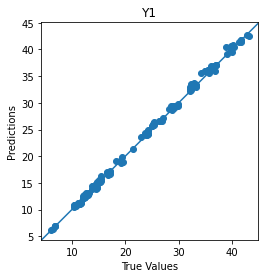

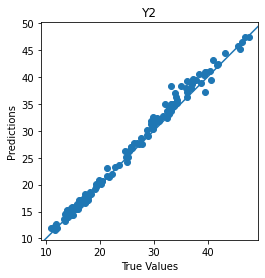

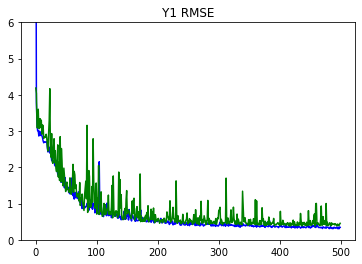

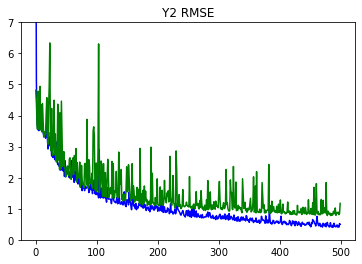

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)